In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras

In [2]:
(X_train, y_train), (X_test, y_test) = tf_keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 1096s 6us/step


In [3]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

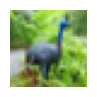

In [12]:
plt.figure(figsize=(1, 1))
plt.imshow(X_train[6])
plt.axis('off')
plt.show()

In [18]:
y_train.shape

(50000, 1)

In [27]:
# 생성 모델 학습 데이터 준비

print( np.unique(y_train) )

X_train_dog = X_train[y_train.flatten() == 5] # 개 이미지만 뽑기

# X_train_dog.max() # 255
X_train_dog_scaled = X_train_dog / X_train_dog.max()
X_train_dog_scaled = X_train_dog_scaled.astype('float32')

X_train_dog_scaled.dtype
X_train_dog.shape

[0 1 2 3 4 5 6 7 8 9]


(5000, 32, 32, 3)

In [13]:
# parameter 설정
width = 32
height = 32
channels = 3
latent_dim = 32 # 이미지 생성을 위해 초기 데이터를 추출하는 데이터 공간

In [28]:
# 판별 모델 구조 설계

# discriminator = tf_keras.models.Sequential([
#     tf_keras.layers.Input(shape=(width, height, channels)),
#     tf_keras.layers.Conv2D(filters=32, kernel_size=3),
#     tf_keras.layers.LeakyReLU(),
#     tf_keras.layers.Conv2D(filters=64, kernel_size=3),
#     tf_keras.layers.LeakyReLU(),
#     tf_keras.layers.Conv2D(filters=64, kernel_size=3),
#     tf_keras.layers.LeakyReLU(),
#     tf_keras.layers.Flatten(),
#     tf_keras.layers.Dense(1, activation="sigmoid")
# ])

d_input = tf_keras.layers.Input(shape=(width, height, channels))
d_x = tf_keras.layers.Conv2D(filters=32, kernel_size=3)(d_input)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Conv2D(filters=64, kernel_size=3)(d_x)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Conv2D(filters=64, kernel_size=3)(d_x)
d_x = tf_keras.layers.LeakyReLU()(d_x)
d_x = tf_keras.layers.Flatten()(d_x)
d_output = tf_keras.layers.Dense(1, activation="sigmoid")(d_x)

discriminator = tf_keras.models.Model(d_input, d_output)

discriminator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 26, 26, 64)        0    

In [29]:
# 판별 모델 학습 설계

discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [34]:
# 생성 모델 구조 설계

g_input = tf_keras.layers.Input(shape=(latent_dim,))
g_x = tf_keras.layers.Dense(units=128*16*16)(g_input)
g_x = tf_keras.layers.LeakyReLU()(g_x)
g_x = tf_keras.layers.Reshape(target_shape=(16, 16, 128))(g_x)

g_x = tf_keras.layers.Conv2D(filters=256, kernel_size=4, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

# Conv2DTranspose : 이미지 확대 ( padding=='same'인 경우 width*stride, height*stride )
g_x = tf_keras.layers.Conv2DTranspose(filters=256, kernel_size=4, 
                                      strides=2, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

g_x = tf_keras.layers.Conv2D(filters=256, kernel_size=4, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)
g_x = tf_keras.layers.Conv2D(filters=256, kernel_size=4, padding="same")(g_x)
g_x = tf_keras.layers.LeakyReLU()(g_x)

g_output = tf_keras.layers.Conv2D(filters=channels, kernel_size=5, 
                                  activation="sigmoid", padding="same")(g_x)

generator = tf_keras.models.Model(g_input, g_output)

generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       1048